## RoBERTa base model continual pre-training

LLM are pre-trained using billions of tokens from publicly and privately source data to learn representations of the our dialec. Although, we have seen high performaning LLMs in many domains with the use of prompting, RAG, and fine-tuning there is a desire to continually pre-train the based models on private domain specific corpus. 

This notebook aims to provide guidance on domain adaptive pre training (DAPT) on a specific sectors data source and using some of the open source data, that was used to pre-train the base model to mitigate **catastrophic forgetting**.

### Machine Specs
- Amazon Web Service - Sagemaker Studio
- Instance: ml.m5.2xlarge
  - Vcpu: 4
  - Mem: 16 GiB
  - x86_64
  - 0 GPU
- Python 3.11.11
- General purpose compute

In [162]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import gc

from typing import Dict, List, Any, Optional
from pathlib import Path
import os
from tqdm import tqdm
import itertools

from datasets import load_dataset

import random

print(f"Pytorch version: {torch.__version__}")
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

try:
    current_file = Path(__file__)
    current_dir = current_file.parent
except (NameError):
    current_dir = Path.cwd()

gc.collect()

Pytorch version: 2.4.1.post100
GPU is not available.


45665

In [119]:
!python -V 

Python 3.11.11


In [3]:
train_dataloader_cfg = dict(
    batch_size=8,
    num_workers=2,
    dataset=dict(
        type='wikipedia',
        data_root='20220301.simple',
        split='train',
        object='text'),
    custom_dataset=dict(
        type='txt',
        data_root='/home/sagemaker-user/custom_data'),
)

model_cfg = dict(
    type='MaskLanguageModeling',
    backbone=dict(
        type='roberta', arch='base'),
)

In [143]:
# Model Loading: Load a pre-trained RoBERTa model
# (you can also use it as the starting point for further training).
def load_model(model_cfg: Dict) -> tuple:
    if ('Mask' in model_cfg.get('type') and
            'roberta' in model_cfg['backbone'].get('type')):
        from transformers import RobertaForMaskedLM, RobertaTokenizer
        backbone = RobertaForMaskedLM
        tokenizer = RobertaTokenizer
    pretrain_model = "-".join(model_cfg.get('backbone').values())
    return (backbone.from_pretrained(pretrain_model),
            tokenizer.from_pretrained(pretrain_model))


# Run
model, tokenizer = load_model(model_cfg)

### Load Data

#### Pre-training datasource from HF
Dataset Summary (https://huggingface.co/datasets/legacy-datasets/wikipedia)

Wikipedia dataset containing cleaned articles of all languages. The datasets are built from the Wikipedia dump (https://dumps.wikimedia.org/) with one split per language. Each example contains the content of one full Wikipedia article with cleaning to strip markdown and unwanted sections (references, etc.).

The articles are parsed using the mwparserfromhell tool.

example datastructure

```json
{'id': '1',
 'url': 'https://simple.wikipedia.org/wiki/April',
 'title': 'April',
 'text': 'April is the fourth month...'
}

```

#### Custom Insurance Data
**Notes:**
- This is a fictional example intended to simulate a customer service call about an auto insurance policy and a claim.
- The conversation covers both the policy purchase (getting a quote, discussing coverage options, and confirming policy details) and the claim process (detailing an accident, filing a claim, and explaining next steps).
- There are no specific indications of who is speaking, as this example assumes that pre-processing of the data and filter has already occurred upstream, but the conversation alternates between the customer and the agent.

#### Masking Strategy

**Notes**
- In the method `mask_tokens()` we take advantage of `torch.nn.CrossEntropyLoss` default value for `ignore_index=-100` to specifies a target value that is ignored and does not contribute to the input gradient. Meaning that tokens that are not "masked" will not contribute to the loss.

#### Optimize Data Transfer
- See https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
- Setting `pin__memory=True` in `DataLoader`

In [5]:
def loader(dataset_cfg: Dict) -> List:
    dataset_cfg = dataset_cfg.get('dataset') or dataset_cfg
    pretrain_data = load_dataset(
        path=dataset_cfg.get('type'),
        name=dataset_cfg.get('data_root'))
    return pretrain_data[dataset_cfg.get('split')][dataset_cfg.get('object')]


# Run
hf_train_data = loader(train_dataloader_cfg.get('dataset'))

Reusing dataset wikipedia (/home/sagemaker-user/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
def load_custom_text_files(dataset_cfg: Dict) -> List:
    """
    Custom data loader that traverses a directory and returns raw text in a list,
    with a progress bar to show the loading process.

    Args:
    - data_dir (str): Path to the directory containing the text files.

    Returns:
    - list: A list of raw text data from all .txt files in the directory.
    """
    dataset_cfg = dataset_cfg.get('custom_dataset') or dataset_cfg
    data_dir = dataset_cfg.get('data_root')
    assert os.path.isdir(data_dir), f"{data_dir} is not a valid dir"
    assert len(os.listdir(data_dir)) > 0, f"{data_dir} is empty"

    print(f"Opening and Loading `.txt` files from local director {data_dir}")
    text_data = []

    # Loader progress bar
    for filename in tqdm(
            os.listdir(data_dir), desc="Loading: ", unit="file", colour="green"
    ):
        file_path = os.path.join(data_dir, filename)

        # Skip directories and non-text files
        if (os.path.isdir(file_path) or 
                not file_path.endswith(dataset_cfg.get('type'))):
            continue

        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            text_data.append(text)

    return text_data


# Run
custom_txt_data = load_custom_text_files(train_dataloader_cfg)

Opening and Loading `.txt` files from local director /home/sagemaker-user/custom_data


Loading: 100%|██████████| 3/3 [00:00<00:00, 5395.76file/s]


In [111]:
class CombinedTextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, mlm_probability=0.15):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mlm_probability = mlm_probability

        vocab = tokenizer.get_vocab()
        self.token_ids = list(vocab.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict:
        text = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_length,
            padding="max_length", truncation=True, return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()
        input_ids, labels = self.mask_tokens(
            tokenizer = self.tokenizer,
            inputs=input_ids,
            token_ids=self.token_ids,
            mlm_probability=self.mlm_probability)

        return {"input_ids": input_ids,
                "attention_mask": attention_mask, "labels": labels}
    @staticmethod
    def broadcast_and_check(
        base: torch.tensor, reference: torch.tensor) -> torch.tensor:
        """
        Broadcast and perform elementwise comparison
        returning index of the base tensor that match any value in the 
        reference tensor.
    
        Args:
            base (torch.tensor): The base tensor.
            reference (torch.tensor): The reference tensor.
    
        Returns:
            torch.tensor: The indices of the base tensor that match any value in the reference tensor.
    
        Example:
            >>> base = torch.tensor([[0, 1 , 2], [0, 3, 0]])
            >>> reference = torch.tensor([0, 20, 80])
            >>> idx = broadcast_and_check(base, reference)
            >>> print(idx)
            tensor([[0, 0],
                    [1, 0],
                    [1, 2]])
        """
        assert reference.ndim == 1, "Reference tensor must be 1-dimentional"
        base_dim = base.ndim
    
        # broadcast with different view of data, +1 dimension
        base = base.unsqueeze(-1)
        reference = reference.unsqueeze(0)
        idx = torch.nonzero(base == reference)
    
        return idx[:, 0:base_dim]

    def mask_tokens(
        self,
        tokenizer: Any, inputs: torch.tensor,
        token_ids: List[int],
        mlm_probability: Optional[float] = 0.15,
        mask_prob: Optional[float] = 0.1,
        same_prob: Optional[float] = 0.1,
        rnd_prob: Optional[float] = 0.8,
        skip_special_tokens: Optional[bool] = False
            ) -> tuple[torch.tensor]:
        """
        Masking method mirroring the strategy utilized in RoBERTa paper.
    
        'BERT uniformly selects 15% of the input tokens for possible replacement.
        Of the selected tokens, 80% are replaced with [MASK ], 10% are left 
        unchanged, and 10% are replaced by a randomly selected vo- cabulary token'
        - Page 2
    
        They can be treated as hyper parameters during training. The default
        implementations are the same as RoBERTa model
        (https://arxiv.org/abs/1907.11692)

        Args:
        - tokenizer: Tokenizer instance.
        - inputs: Input tensor.
        - mlm_probability: Probability of masking a token. Defaults to 0.15.
        - mask_prob: Probability of replacing a masked token with [MASK]. Defaults to 0.8.
        - same_prob: Probability of leaving a masked token unchanged. Defaults to 0.1.
        - rnd_prob: Probability of replacing a masked token with a random vocabulary token. Defaults to 0.1.
        - skip_special_tokens: Whether to skip masking special tokens. Defaults to False.

        Returns:
        - inputs: Modified input tensor with masked tokens.
        - labels: Labels tensor for MLM task.
        """
        labels = inputs.clone()
        mask = torch.rand(inputs.shape) < mlm_probability
        # Skip special token masking
        if not skip_special_tokens:
            idx = self.broadcast_and_check(inputs,
                                      torch.tensor(tokenizer.all_special_ids))
            mask[idx] = False

        # Replace with mask/same/rand token & set unmask label -100
        # to ignore during loss calculation
        # TODO: Currently this is a single random variable, applied to all tokens
        # it should be applied on a per token basis instead.
        replacement_prob = torch.rand(1)
        if replacement_prob <= mask_prob:
            print("Replacement with <mask> token")
            inputs[mask] = tokenizer.mask_token_id
        elif replacement_prob <= mask_prob + rnd_prob:
            # Since elif is cascading if the first statement is not met than
            # the elif is checked
            a = random.choice(token_ids)
            print(f"Replacement with random token from vocab: {tokenizer.decode(a)}")
            inputs[mask] = a
        else:
            print("No Token Replacement")
            pass

        labels[~mask] = -100
        return inputs, labels


# Create dataset for Hugging Face and custom data
hf_train_dataset = CombinedTextDataset(data=hf_train_data, tokenizer=tokenizer)
custom_train_dataset = CombinedTextDataset(
    data=custom_txt_data, tokenizer=tokenizer)

# Concatenate the datasets into one
combined_dataset = ConcatDataset([hf_train_dataset, custom_train_dataset])

# Create a single DataLoader for the combined dataset
train_dataloader = DataLoader(combined_dataset, batch_size=8, shuffle=True, pin_memory=True)
custom_dataloader = DataLoader(custom_train_dataset, batch_size=8, shuffle=True, pin_memory=True)

### Pre-Training Setup

Following reference [1] we can take develop an efficient continual pre- training by implementing a re-increase a small learning rate to pre-train on new data, known as 're-warming'. Re-warming the model should improve learning efficiency by avoiding a vanishing learning rate.
 
- Optimizer and Scheduler: Set up an optimizer (typically AdamW) and a learning rate scheduler.

Reference:
1. [Continual Pre-Training of Large Language Models: How to (re)warm your model](https://arxiv.org/abs/2308.04014)

In [160]:
from transformers import get_cosine_schedule_with_warmup
from torch.optim import AdamW

NUM_EPOCHS =  3
optimizer = AdamW(
    model.parameters(),
    betas=(0.9,0.95), 
    eps=1e-8,
    weight_decay=0.1,
    lr=6e-4)

# Compute the number of warmup steps (example: 1% of total steps)
num_warmup_steps = int(0.01 * len(train_dataloader) * NUM_EPOCHS)
num_training_steps = len(train_dataloader) * NUM_EPOCHS

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

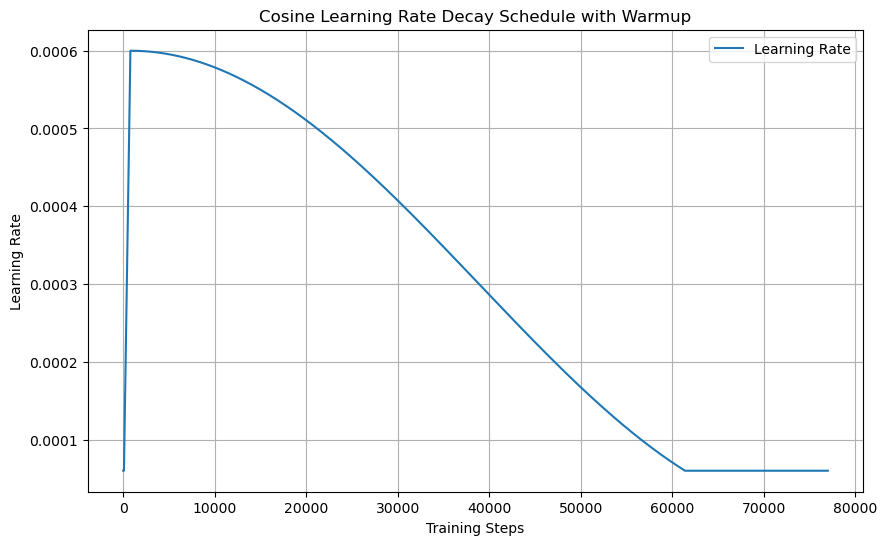

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the learning rate at each step (without training the model)
lr_values = []
for i, step in enumerate(range(num_training_steps)):
    MAX_LR = 0.1 * 6e-4

    # We are not able to explicitly set a MinLr in get_cosine_schedule_with_warmup, look to make that change explicitly 
    # in the training loop
    # https://github.com/huggingface/transformers/issues/26209
    lr = MAX_LR if scheduler.get_lr()[0] < MAX_LR else scheduler.get_lr()[0]
    lr_values.append(lr)  # Get current learning rate
    scheduler.step()
    
# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_training_steps), lr_values, label="Learning Rate")
plt.title("Cosine Learning Rate Decay Schedule with Warmup")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#reclaim mem before training
gc.collect()

In [116]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Set the model to training mode")
model.train()
NUM_EPOCHS = 3
VERBOSE = False


def recreate_original_text(input_ids, labels, tokenizer):
    # Replace masked tokens in input_ids with corresponding tokens from labels
    # (where labels != -100)
    input_ids_cp = input_ids.clone()
    labels_cp = labels.clone()
    for i in range(len(input_ids_cp))   
        if labels_cp[i] != -100:  
    # If the label is not -100, it's the original token
            input_ids_cp[i] = labels_cp[i]

    # Convert the token IDs back to text using the tokenizer's decode function
    original_text = tokenizer.decode(input_ids_cp, skip_special_tokens=True)

    return original_text


# Training loop
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    # for batch in itertools.islice(train_dataloader, 1):
    for batch in train_dataloader:
        print("batch start")
        # Get input data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs
        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass: compute gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Update learning rate scheduler
        scheduler.step()
        
        # Get predictions (logits for each token in the sequence)
        logits = outputs.logits
        
        # Convert logits to predicted token ids (using softmax to get probabilities)
        predicted_token_ids = torch.argmax(logits, dim=-1)
        # Decode predicted token ids back to text
        predicted_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

        # Decode input text (the original text)
        original_text = recreate_original_text(input_ids[0],labels[0], tokenizer)

        # Masked Text (where we replace the original tokens with [MSK])
        masked_text = tokenizer.decode(input_ids[0], skip_special_tokens=False)

        if VERBOSE:
            print(f"Original text: {original_text}")
            print("------------------------------------")
            print(f"Masked text: {masked_text}")
            print("------------------------------------")
            print(f"Predicted text: {predicted_text}")
        print("batch ended")   
    # Print loss for each epoch
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {total_loss / len(train_dataloader)}")

    if torch.cuda.is_available:
        # release unused memory
        torch.cuda.empty_cache()

Set the model to training mode
Replacement with random token from vocab:  condol
Replacement with random token from vocab:  candle
batch start
Original text: I’m calling to get a quote for a new auto insurance policy.

Sure! I'd be happy to assist you. May I have your name and some details about the vehicle you're looking to insure?

Yes, my name is Sarah Jenkins, and I drive a 2020 Toyota Camry. It's in excellent condition, and I’ve had it for about 3 months now.

Great, Sarah! Let me take a look at the information. Is this the first time you’ve purchased auto insurance, or do you have a policy elsewhere right now?

I’ve had insurance before, but this is a new car, so I need to switch over and get coverage on this vehicle.

Got it. Let me pull up the details for you. We can offer different types of coverage, including liability, collision, and comprehensive. Would you like to discuss the different options available?

Yes, I’d definitely like to know more about those. I’m mainly concer

## Appendix

In [153]:
import subprocess

def get_disk_usage():
    output = subprocess.check_output(['df', '-h']).decode('utf-8')
    return output

print(get_disk_usage())

Filesystem      Size  Used Avail Use% Mounted on
overlay          37G   40K   37G   1% /
tmpfs            64M     0   64M   0% /dev
tmpfs            16G     0   16G   0% /sys/fs/cgroup
shm             3.8G   76K  3.8G   1% /dev/shm
/dev/nvme1n1     20G  968M   20G   5% /home/sagemaker-user
/dev/nvme0n1p1  180G   31G  150G  17% /opt/.sagemakerinternal
127.0.0.1:/     8.0E     0  8.0E   0% /mnt/custom-file-systems/efs/fs-0f6c2f8c96c6bcca7_fsap-0f2918b593fd98f93
tmpfs            16G     0   16G   0% /proc/acpi
tmpfs            16G     0   16G   0% /sys/firmware



In [154]:
# Expand Vocubulary

In [ ]:
# # Advanced Approach: Weighted Sampling
# # If you'd like to control the proportion of samples coming from each dataset (e.g., 70% Hugging Face data and 30% custom data), you can use weighted random sampling. This can be done by using the WeightedRandomSampler in PyTorch to bias the sampling towards one dataset or another.

# # Here’s how you could do it:

# from torch.utils.data import WeightedRandomSampler

# # Define weights for each dataset (adjust these as needed)
# hf_weight = 0.7  # 70% of samples from the Hugging Face dataset
# custom_weight = 0.3  # 30% from custom dataset

# # Create a list of weights for each item in the combined dataset
# weights = [hf_weight] * len(hf_train_dataset) + [custom_weight] * len(custom_train_dataset)

# # Create a WeightedRandomSampler
# sampler = WeightedRandomSampler(weights, len(weights))

# # Create a DataLoader with the sampler
# train_dataloader = DataLoader(combined_dataset, batch_size=8, sampler=sampler)

# # Check a sample batch
# for batch in train_dataloader:
#     print(batch)
#     break
